# Small World Networks: The Watts-Strogatz Model

## Introduction

Small world networks are a class of graphs that exhibit two key properties: **high clustering** (like regular lattices) and **short average path lengths** (like random graphs). This phenomenon was formalized by Duncan Watts and Steven Strogatz in their seminal 1998 paper, providing a mathematical framework to understand networks ranging from social connections to neural architectures.

## Theoretical Foundation

### The Watts-Strogatz Model

The construction proceeds as follows:

1. **Start with a ring lattice**: Arrange $N$ nodes in a ring, each connected to its $K$ nearest neighbors ($K/2$ on each side)

2. **Rewire edges**: For each edge, with probability $p$, rewire one endpoint to a randomly chosen node (avoiding self-loops and duplicate edges)

### Key Metrics

**Clustering Coefficient**: Measures the degree to which neighbors of a node are also neighbors of each other.

For a node $i$ with degree $k_i$, the local clustering coefficient is:

$$C_i = \frac{2 E_i}{k_i(k_i - 1)}$$

where $E_i$ is the number of edges between the neighbors of node $i$.

The global clustering coefficient is the average:

$$C = \frac{1}{N} \sum_{i=1}^{N} C_i$$

**Average Path Length**: The mean shortest path distance between all pairs of nodes:

$$L = \frac{1}{N(N-1)} \sum_{i \neq j} d(i, j)$$

where $d(i, j)$ is the shortest path length between nodes $i$ and $j$.

### The Small World Regime

The remarkable finding is that for intermediate values of $p$ (approximately $0.01 < p < 0.1$):

- The clustering coefficient $C(p)$ remains close to $C(0)$ (the regular lattice value)
- The average path length $L(p)$ drops dramatically toward $L(1)$ (the random graph value)

This creates a network that is simultaneously highly clustered and has short path lengths—the hallmark of small world networks.

### Theoretical Predictions

For a ring lattice with $K \gg \ln N \gg 1$:

- Regular lattice ($p=0$): $C(0) \approx \frac{3(K-2)}{4(K-1)}$, $L(0) \approx \frac{N}{2K}$
- Random graph ($p=1$): $C(1) \approx \frac{K}{N}$, $L(1) \approx \frac{\ln N}{\ln K}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Set random seed for reproducibility
np.random.seed(42)

## Implementation

### Watts-Strogatz Graph Generator

We implement the algorithm to construct small world networks from scratch.

In [2]:
def create_ring_lattice(n, k):
    """
    Create a ring lattice with n nodes, each connected to k nearest neighbors.
    
    Parameters:
    -----------
    n : int
        Number of nodes
    k : int
        Each node is connected to k nearest neighbors (k/2 on each side)
        
    Returns:
    --------
    adj_list : list of sets
        Adjacency list representation of the graph
    """
    adj_list = [set() for _ in range(n)]
    
    for i in range(n):
        for j in range(1, k // 2 + 1):
            # Connect to neighbors on both sides
            neighbor_right = (i + j) % n
            neighbor_left = (i - j) % n
            adj_list[i].add(neighbor_right)
            adj_list[i].add(neighbor_left)
            adj_list[neighbor_right].add(i)
            adj_list[neighbor_left].add(i)
    
    return adj_list


def watts_strogatz(n, k, p):
    """
    Generate a Watts-Strogatz small world network.
    
    Parameters:
    -----------
    n : int
        Number of nodes
    k : int
        Each node starts connected to k nearest neighbors
    p : float
        Rewiring probability (0 <= p <= 1)
        
    Returns:
    --------
    adj_list : list of sets
        Adjacency list of the generated graph
    """
    # Start with ring lattice
    adj_list = create_ring_lattice(n, k)
    
    # Rewire edges
    for i in range(n):
        for j in range(1, k // 2 + 1):
            if np.random.random() < p:
                # Original neighbor to potentially rewire
                old_neighbor = (i + j) % n
                
                # Choose new target (avoid self-loops and existing edges)
                possible_targets = set(range(n)) - {i} - adj_list[i]
                
                if possible_targets:
                    new_neighbor = np.random.choice(list(possible_targets))
                    
                    # Remove old edge
                    adj_list[i].discard(old_neighbor)
                    adj_list[old_neighbor].discard(i)
                    
                    # Add new edge
                    adj_list[i].add(new_neighbor)
                    adj_list[new_neighbor].add(i)
    
    return adj_list

### Network Metrics Computation

We implement functions to compute the clustering coefficient and average path length.

In [3]:
def clustering_coefficient(adj_list):
    """
    Compute the average clustering coefficient of the network.
    
    Parameters:
    -----------
    adj_list : list of sets
        Adjacency list representation
        
    Returns:
    --------
    float
        Average clustering coefficient
    """
    n = len(adj_list)
    total_cc = 0.0
    
    for i in range(n):
        neighbors = list(adj_list[i])
        k_i = len(neighbors)
        
        if k_i < 2:
            continue
        
        # Count edges between neighbors
        edges_between_neighbors = 0
        for idx, u in enumerate(neighbors):
            for v in neighbors[idx + 1:]:
                if v in adj_list[u]:
                    edges_between_neighbors += 1
        
        # Local clustering coefficient
        possible_edges = k_i * (k_i - 1) / 2
        total_cc += edges_between_neighbors / possible_edges
    
    return total_cc / n


def average_path_length(adj_list):
    """
    Compute the average shortest path length using BFS.
    
    Parameters:
    -----------
    adj_list : list of sets
        Adjacency list representation
        
    Returns:
    --------
    float
        Average path length
    """
    n = len(adj_list)
    total_distance = 0
    num_pairs = 0
    
    for start in range(n):
        # BFS from start node
        distances = [-1] * n
        distances[start] = 0
        queue = deque([start])
        
        while queue:
            current = queue.popleft()
            for neighbor in adj_list[current]:
                if distances[neighbor] == -1:
                    distances[neighbor] = distances[current] + 1
                    queue.append(neighbor)
        
        # Sum distances to all other nodes
        for end in range(start + 1, n):
            if distances[end] > 0:
                total_distance += distances[end]
                num_pairs += 1
    
    return total_distance / num_pairs if num_pairs > 0 else 0

## Simulation: Exploring the Small World Transition

We now simulate networks across a range of rewiring probabilities $p$ to observe the emergence of small world properties.

In [4]:
# Network parameters
N = 100  # Number of nodes
K = 6    # Initial degree (each node connected to K nearest neighbors)

# Range of rewiring probabilities (logarithmic scale)
p_values = np.logspace(-4, 0, 20)

# Number of realizations for averaging
num_trials = 5

# Storage for results
clustering_values = []
path_length_values = []

print("Computing network metrics across rewiring probabilities...")
print(f"N = {N}, K = {K}, Trials = {num_trials}\n")

for p in p_values:
    c_trials = []
    l_trials = []
    
    for _ in range(num_trials):
        graph = watts_strogatz(N, K, p)
        c_trials.append(clustering_coefficient(graph))
        l_trials.append(average_path_length(graph))
    
    clustering_values.append(np.mean(c_trials))
    path_length_values.append(np.mean(l_trials))

# Normalize by p=0 values for comparison
C_0 = clustering_values[0]
L_0 = path_length_values[0]

C_normalized = np.array(clustering_values) / C_0
L_normalized = np.array(path_length_values) / L_0

print(f"Reference values at p ≈ 0:")
print(f"  Clustering coefficient C(0) = {C_0:.4f}")
print(f"  Average path length L(0) = {L_0:.4f}")

Computing network metrics across rewiring probabilities...
N = 100, K = 6, Trials = 5



Reference values at p ≈ 0:
  Clustering coefficient C(0) = 0.6000
  Average path length L(0) = 8.7576


## Visualization

We plot the normalized clustering coefficient $C(p)/C(0)$ and average path length $L(p)/L(0)$ as functions of $p$.


Figure saved to 'plot.png'


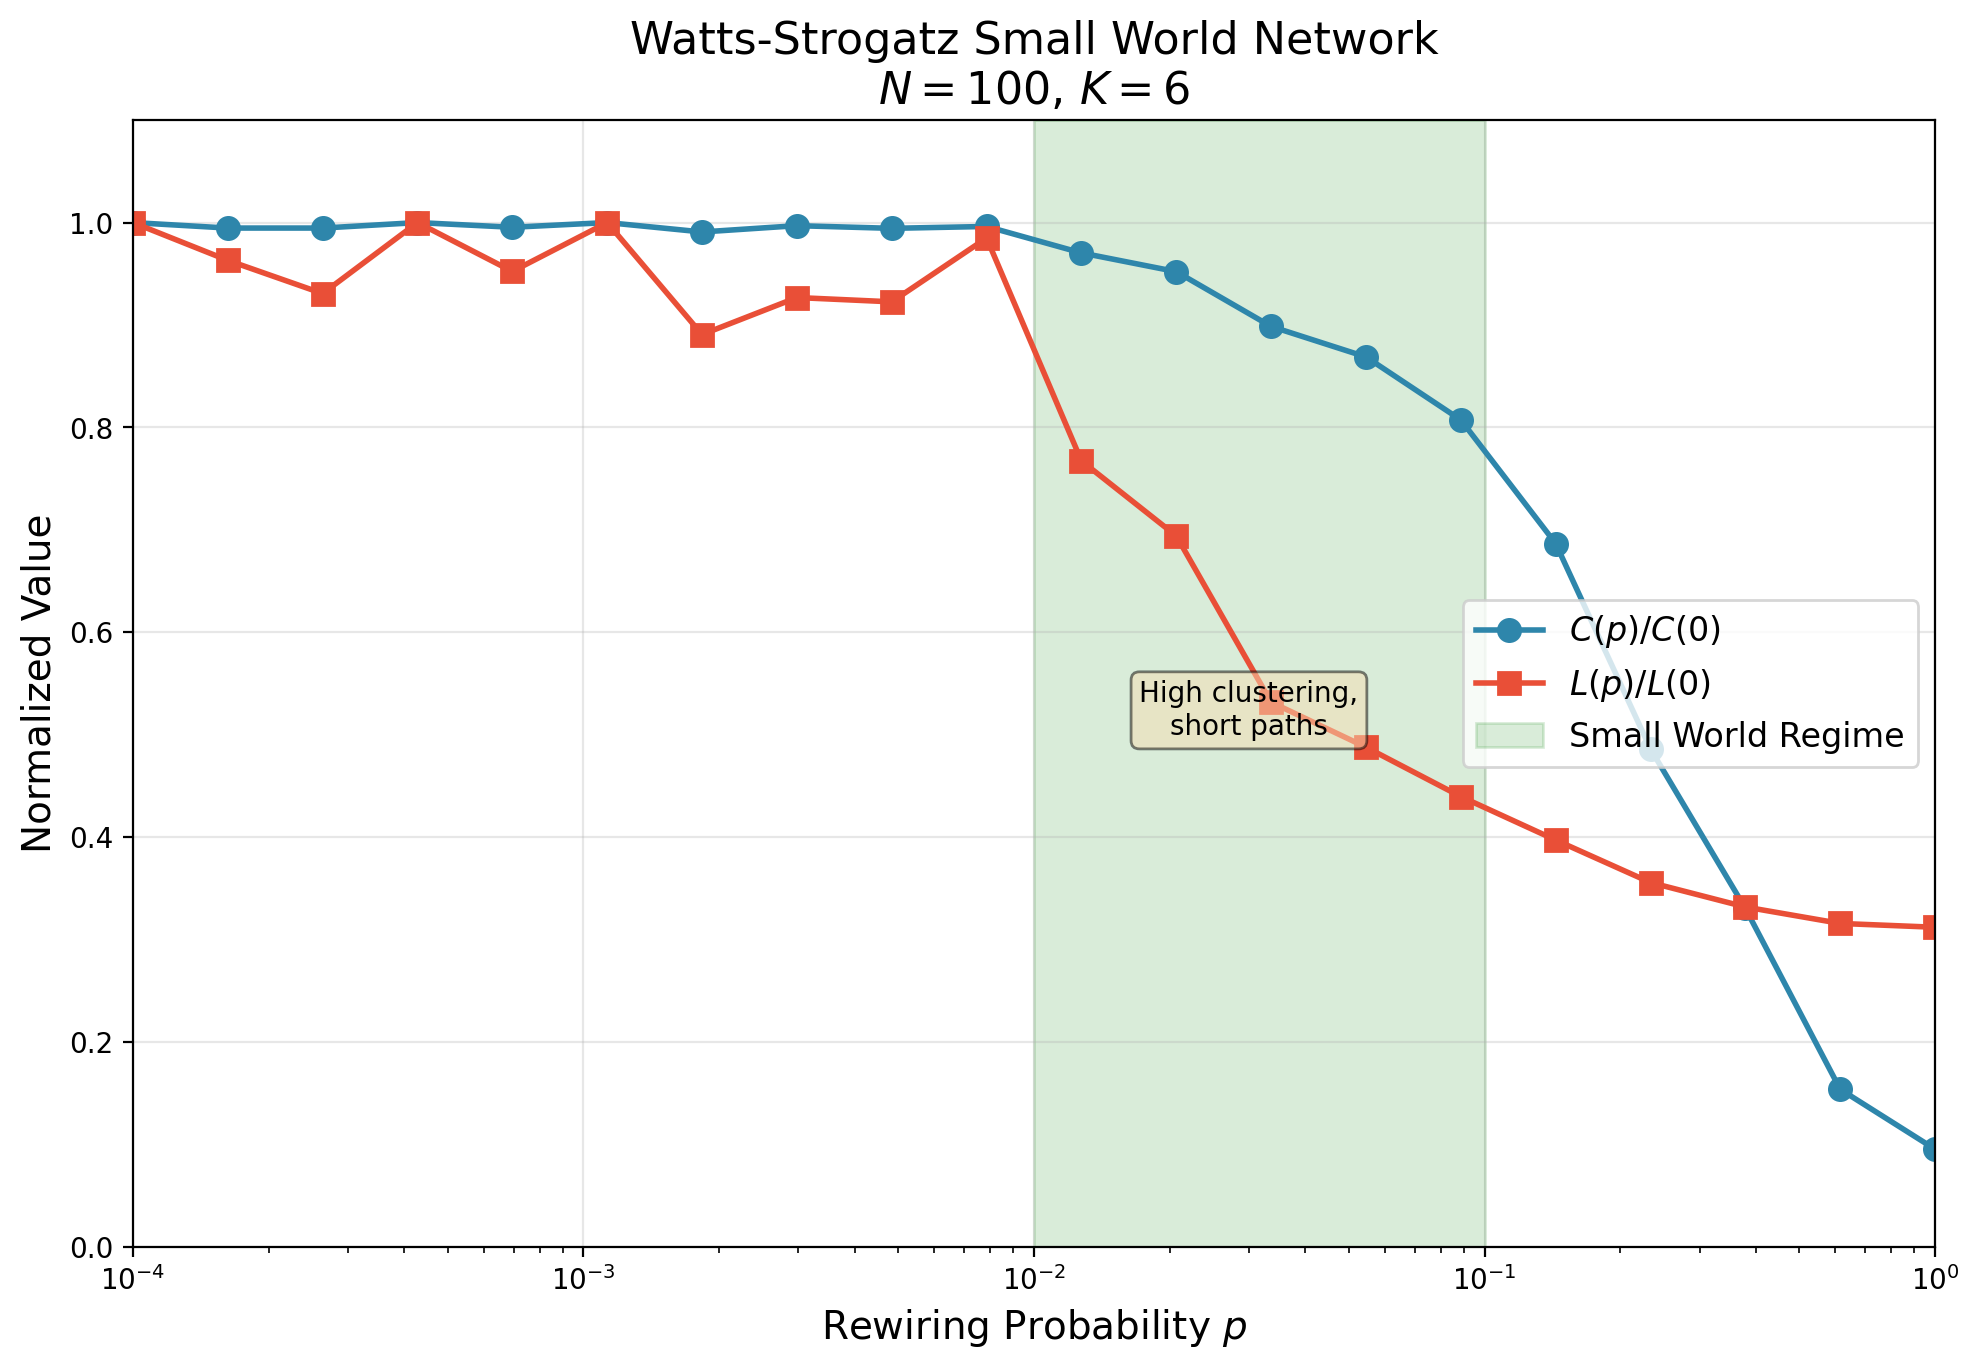

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))

# Plot normalized metrics
ax.semilogx(p_values, C_normalized, 'o-', color='#2E86AB', 
            linewidth=2, markersize=8, label=r'$C(p)/C(0)$')
ax.semilogx(p_values, L_normalized, 's-', color='#E94F37', 
            linewidth=2, markersize=8, label=r'$L(p)/L(0)$')

# Highlight small world regime
ax.axvspan(0.01, 0.1, alpha=0.15, color='green', label='Small World Regime')

# Labels and formatting
ax.set_xlabel('Rewiring Probability $p$', fontsize=14)
ax.set_ylabel('Normalized Value', fontsize=14)
ax.set_title('Watts-Strogatz Small World Network\n'
             f'$N = {N}$, $K = {K}$', fontsize=16)
ax.legend(fontsize=12, loc='center right')
ax.grid(True, alpha=0.3)
ax.set_xlim([p_values[0], p_values[-1]])
ax.set_ylim([0, 1.1])

# Add annotation
ax.annotate('High clustering,\nshort paths', 
            xy=(0.03, 0.5), fontsize=10, ha='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

# Save the figure
plt.savefig('small_world_network_analysis.png', dpi=150, bbox_inches='tight')
print("\nFigure saved to 'plot.png'")

plt.show()

## Analysis and Discussion

### Key Observations

1. **Rapid decrease in path length**: The average path length $L(p)$ drops sharply even for small rewiring probabilities ($p \approx 0.01$). A few random "shortcuts" dramatically reduce the typical distance between nodes.

2. **Robust clustering**: The clustering coefficient $C(p)$ remains high until $p$ becomes substantial ($p > 0.1$). Local structure is preserved despite global shortcuts.

3. **Small world regime**: In the intermediate range $0.01 < p < 0.1$, both properties coexist—this is the "small world" regime where networks are simultaneously clustered and efficient.

### Real-World Implications

Many real networks exhibit small world properties:

- **Social networks**: High local clustering (friends of friends tend to be friends) with short average separation ("six degrees of separation")
- **Neural networks**: Densely connected local circuits with long-range connections enabling rapid information transfer
- **Power grids**: Local redundancy for reliability with long-distance transmission lines

### Mathematical Insight

The asymmetry between $L(p)$ and $C(p)$ arises because:

- Path length is a **global** property sensitive to any shortcuts
- Clustering is a **local** property requiring many rewirings to disrupt

This separation of scales is what makes small world networks possible and ubiquitous in nature.

In [6]:
# Display final statistics
print("\n" + "="*50)
print("SUMMARY OF RESULTS")
print("="*50)

# Find small world regime values
idx_sw = np.argmin(np.abs(p_values - 0.05))  # p ≈ 0.05

print(f"\nAt p = {p_values[idx_sw]:.4f} (small world regime):")
print(f"  C(p)/C(0) = {C_normalized[idx_sw]:.3f} (clustering retained: {C_normalized[idx_sw]*100:.1f}%)")
print(f"  L(p)/L(0) = {L_normalized[idx_sw]:.3f} (path length reduced to {L_normalized[idx_sw]*100:.1f}%)")

print(f"\nAt p = 1.0 (random graph):")
print(f"  C(p)/C(0) = {C_normalized[-1]:.3f}")
print(f"  L(p)/L(0) = {L_normalized[-1]:.3f}")

print("\n" + "="*50)


SUMMARY OF RESULTS

At p = 0.0546 (small world regime):
  C(p)/C(0) = 0.869 (clustering retained: 86.9%)
  L(p)/L(0) = 0.488 (path length reduced to 48.8%)

At p = 1.0 (random graph):
  C(p)/C(0) = 0.095
  L(p)/L(0) = 0.312

